In [1]:
# Importing required Libraries

In [43]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
# from sklearn.externals import joblib
# import Recommenders as Recommenders
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [8]:
# 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [44]:
df = pd.read_csv("C:\\Users\\hp\\Desktop\\Electronic_dataset.csv")
df.head()

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


In [45]:
df.shape

(500000, 4)

In [46]:
df.dtypes

user_id       object
prod_id       object
ratings      float64
timestamp      int64
dtype: object

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    500000 non-null  object 
 1   prod_id    500000 non-null  object 
 2   ratings    500000 non-null  float64
 3   timestamp  500000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


In [48]:
# We can discard the time stamp from dataset as this is not significant for our case.
dfNew = df.drop("timestamp", axis = 1)
dfNew.head()

,user_id,prod_id,ratings
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0
2,A1SINU2I4IOPNU,B000GBO9IM,4.0
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0


In [49]:
dfNew.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,500000.0,4.013172,1.379996,1.0,3.0,5.0,5.0,5.0


In [50]:
print("Number of unique Users : ",len(dfNew.user_id.unique()))      
print("Number of unique Products", len(dfNew.prod_id.unique()))

Number of unique Users :  448368
Number of unique Products 130138


In [52]:
# We conclude the following :-
#  - Number of unique Users :  448368
#  - Number of unique Products 130138
#  - The minumum rating is 1 and maximum rating is 5, so from this we can assume that ratings are give in the scale of 1 to 5 

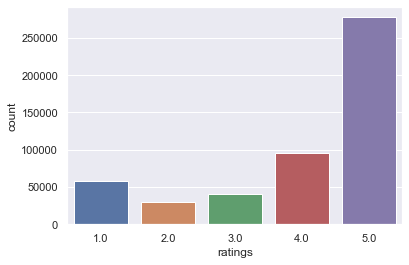

In [54]:
# Distribution of Ratings

sns.set(style="darkgrid")
ax = sns.countplot(x="ratings", data=dfNew)

In [60]:
# Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 5 or more number of ratings )

In [61]:
users = dfNew['user_id'].value_counts()
dfUpdated = dfNew[dfNew['user_id'].isin(users[users >= 5].index)]

dfUpdated.head()

,user_id,prod_id,ratings
26,A2HX3D3MPPASNS,B004I3VZM2,4.0
214,AZNUHQSHZHSUE,B000FJEYZI,1.0
264,A1YEPFLLH42OU1,B00E3W15P0,5.0
286,A2GYV87WW0DMSN,B0009Y7APU,5.0
326,A2IXMLO29Z5G8S,B002K46DDC,5.0


In [62]:
print("Number if users who have rated greaterthan or equal to 5 :", len(dfUpdated)) #.count())
print("Unique number of Items :", len(dfUpdated.prod_id.unique()))
print("Unique number of Users :", len(dfUpdated.user_id.unique()))

Number if users who have rated greaterthan or equal to 5 : 8447
Unique number of Items : 6832
Unique number of Users : 1231


In [63]:
dfUpdated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8447 entries, 26 to 499955
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  8447 non-null   object 
 1   prod_id  8447 non-null   object 
 2   ratings  8447 non-null   float64
dtypes: float64(1), object(2)
memory usage: 264.0+ KB


In [64]:
dfUpdated.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,8447.0,4.255357,1.083217,1.0,4.0,5.0,5.0,5.0


In [65]:
# 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [66]:
train_data, test_data = train_test_split(dfUpdated, test_size = 0.3, random_state=0)
train_data.head(5)

,user_id,prod_id,ratings
78936,A2SYAQXJGRY3XE,B00009UTZA,4.0
297326,A2BYV7S1QP2YIG,B00JF7LR4C,5.0
443551,AFNG8O2DXRCUV,B003UT6C9G,3.0
245378,AOCBGDKF09QLU,B003F8UWV6,5.0
403581,A10ZBR6O8S8OCY,B00FA4Y7N2,5.0


In [67]:
train_data.shape

(5912, 3)

In [68]:
test_data.shape

(2535, 3)

In [69]:
# 2. Build Popularity Recommender model.

In [71]:
df_train_grouped = train_data.groupby(['prod_id']).agg({'user_id': 'count'}).reset_index()
df_tarin_sorted = df_train_grouped.sort_values(['user_id','prod_id'], ascending=[0,1])
# Top 5 Recomendation ID
popular_items = df_tarin_sorted.head(5)

In [73]:

# Function to return popular item. As this is not a personalised one this function returns the most popular items based on user crowd ratings on a product

def recomend_items(userid):
    recommendations = popular_items 
    recommendations['user_id'] = userid 
    return recommendations

In [74]:
recomend_items('A2NWSAGRHCP8N5')

,prod_id,user_id
2301,B003ES5ZUU,A2NWSAGRHCP8N5
3801,B007WTAJTO,A2NWSAGRHCP8N5
2014,B002SZEOLG,A2NWSAGRHCP8N5
2041,B002V88HFE,A2NWSAGRHCP8N5
3250,B005FYNSPK,A2NWSAGRHCP8N5


In [75]:
# 4. Build Collaborative Filtering model.
# 6. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [77]:
#Creating a sparse pivot table with users in rows and items in columns
pivot_matrix_df = dfUpdated.pivot(index='user_id', columns='prod_id', values='ratings').fillna(0)

pivot_matrix_df.head(10)

prod_id,1400501466,1400532655,9985511476,B000001OM4,B000006OQ8,B00000DM9M,B00000DM9W,B00000DMA3,B00000J1US,B00000J4VK,...,B00KHA2DQM,B00KHA5G6G,B00KIMX4EY,B00KK9481I,B00KMRGB7C,B00KMRGF28,B00KWMNDDM,B00KYMCJF8,B00L2442H0,B00L26YDA4
user_id,,,,,,,,,,,,,,,,,,,,,
A0655860XQH1M5Q8JH1M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A107D9T206Z36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10M0GF5ZFODYU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
pivot_matrix_df['index'] = np.arange(0, pivot_matrix_df.shape[0], 1)
pivot_matrix_df.head()
pivot_matrix_df.set_index(['index'], inplace=True)

# Actual ratings given by users
pivot_matrix_df.head()

prod_id,1400501466,1400532655,9985511476,B000001OM4,B000006OQ8,B00000DM9M,B00000DM9W,B00000DMA3,B00000J1US,B00000J4VK,...,B00KHA2DQM,B00KHA5G6G,B00KIMX4EY,B00KK9481I,B00KMRGB7C,B00KMRGF28,B00KWMNDDM,B00KYMCJF8,B00L2442H0,B00L26YDA4
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
from scipy.sparse.linalg import svds

In [80]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 5
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(pivot_matrix_df, k = NUMBER_OF_FACTORS_MF)

In [81]:
U.shape

(1231, 5)

In [82]:
Vt.shape

(5, 6832)

In [83]:
sigma = np.diag(sigma)
sigma.shape

(5, 5)

In [84]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-2.83225276e-23,  7.55995750e-21,  3.47124257e-21, ...,
         1.61970893e-17,  6.68591622e-18,  1.32643412e-21],
       [ 2.52406430e-07,  8.27588773e-06,  1.05039414e-05, ...,
        -2.76647284e-02, -2.48738331e-03,  3.30881572e-06],
       [ 6.34985261e-08,  6.74568315e-06,  4.90744009e-06, ...,
        -8.31562548e-03,  2.48288361e-03,  2.19189673e-06],
       ...,
       [ 5.16959930e-23,  7.03832802e-21,  4.83033568e-21, ...,
         6.13643082e-20,  4.02090690e-18,  3.08727822e-21],
       [ 1.41513732e-09,  9.94600782e-07,  5.40727749e-07, ...,
         2.74601676e-04,  6.61316481e-04,  2.81048356e-07],
       [ 1.36549376e-08,  8.35610231e-06,  4.54942604e-06, ...,
         5.62764854e-04,  5.34410360e-03,  2.46068935e-06]])

In [85]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_matrix_df.columns)
cf_preds_df.head(10)

prod_id,1400501466,1400532655,9985511476,B000001OM4,B000006OQ8,B00000DM9M,B00000DM9W,B00000DMA3,B00000J1US,B00000J4VK,...,B00KHA2DQM,B00KHA5G6G,B00KIMX4EY,B00KK9481I,B00KMRGB7C,B00KMRGF28,B00KWMNDDM,B00KYMCJF8,B00L2442H0,B00L26YDA4
0,-2.832253e-23,7.559958e-21,3.471243e-21,-4.516820e-22,2.818672e-19,1.260763e-19,-8.742341e-34,1.411485e-21,-8.258736e-21,-5.741653e-34,...,-6.607650e-21,-4.282954e-21,-5.035860e-19,1.295342e-20,1.619709e-17,1.024845e-19,6.649810e-35,1.619709e-17,6.685916e-18,1.326434e-21
1,2.524064e-07,8.275888e-06,1.050394e-05,-8.544824e-07,-1.666687e-04,-2.207668e-04,2.636380e-18,-3.856345e-07,3.921719e-05,2.201912e-18,...,5.247354e-05,3.472379e-05,1.551745e-02,7.379824e-05,-2.766473e-02,-7.971062e-05,-1.728013e-19,-2.766473e-02,-2.487383e-03,3.308816e-06
2,6.349853e-08,6.745683e-06,4.907440e-06,-2.491248e-07,9.464030e-05,-1.901430e-05,3.567902e-19,6.299838e-07,1.024369e-05,4.175948e-19,...,2.969603e-05,8.737507e-06,3.169267e-03,3.792507e-05,-8.315625e-03,2.905413e-05,-2.243250e-20,-8.315625e-03,2.482884e-03,2.191897e-06
3,1.089728e-09,4.859152e-07,2.646392e-07,-6.853364e-09,1.226785e-05,2.433192e-06,-1.533460e-20,6.771862e-08,1.372744e-07,-3.778357e-21,...,1.346696e-06,1.452622e-07,5.370735e-06,2.204856e-06,-2.599610e-04,4.316021e-06,1.219841e-21,-2.599610e-04,2.832238e-04,1.475408e-07
4,2.166778e-11,6.726398e-10,7.330652e-10,2.443818e-11,-1.963361e-08,-3.077597e-08,2.380009e-22,-5.116873e-11,4.548715e-09,2.084152e-22,...,1.216818e-08,3.058917e-09,6.206174e-07,8.499538e-09,-7.077355e-06,-8.503880e-09,-1.754727e-23,-7.077355e-06,-4.975887e-07,4.197825e-10
5,3.000202e-10,1.994809e-08,2.407942e-08,-2.674312e-10,3.945235e-07,6.319815e-07,2.517674e-22,1.971926e-09,3.917123e-08,2.087276e-21,...,8.556792e-08,4.432344e-08,4.371134e-05,2.352426e-07,2.251181e-04,1.185910e-07,-6.711089e-24,2.251181e-04,2.475450e-05,9.010905e-09
6,5.329104e-09,2.198030e-06,1.197626e-06,3.181314e-08,5.368096e-05,1.111447e-05,-5.499684e-20,2.981549e-07,6.194421e-07,-6.549005e-21,...,5.941981e-06,7.414315e-07,1.050261e-05,1.257045e-05,-1.281115e-03,1.889306e-05,4.715836e-21,-1.281115e-03,1.280325e-03,7.913831e-07
7,3.297313e-09,8.382830e-07,5.362139e-07,-9.710004e-09,2.073416e-05,7.865563e-06,-2.230626e-20,1.127129e-07,3.868373e-07,5.791105e-21,...,2.288021e-06,4.650407e-07,2.786521e-04,4.760623e-06,1.098390e-03,7.181086e-06,1.896728e-21,1.098390e-03,5.787955e-04,2.760510e-07
8,2.163741e-09,1.621516e-06,8.965252e-07,-2.395467e-08,4.540644e-05,1.539282e-05,-8.336270e-20,2.418175e-07,8.480894e-08,-2.998527e-20,...,3.612643e-06,2.917436e-07,1.356785e-04,7.449033e-06,1.170999e-03,1.610247e-05,6.399274e-21,1.170999e-03,1.132852e-03,4.828112e-07
9,2.379436e-07,1.179615e-04,6.432651e-05,-1.853189e-06,3.048569e-03,6.937053e-04,-4.197975e-18,1.669588e-05,2.547848e-05,-1.242353e-18,...,3.015224e-04,3.151481e-05,2.935453e-03,5.283003e-04,-3.403405e-02,1.074420e-03,3.333518e-19,-3.403405e-02,7.136813e-02,3.534215e-05


In [86]:
def recommend_items_CF(userId, pivot_matrix_df, cf_preds_df, num_recommendations):
      
    user_idx = userId-1
    sorted_user_ratings = pivot_matrix_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = cf_preds_df.iloc[user_idx].sort_values(ascending=False)
    result = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    result.index.name = 'Recommended Products'
    result.columns = ['user_ratings', 'user_predictions']
    result = result.loc[result.user_ratings == 0]   
    result = result.sort_values('user_predictions', ascending=False)
    return result.head(num_recommendations)

In [87]:
# Call Collaborative recomendation method:
userId = 100
num_recommendations = 5
result = recommend_items_CF(userId, pivot_matrix_df, cf_preds_df, num_recommendations)
print("Recommendation for UserId :")
print(result)

Recommendation for UserId :
                      user_ratings  user_predictions
Recommended Products                                
B003ES5ZUU                     0.0          0.000840
B007WTAJTO                     0.0          0.000424
B003ES5ZSW                     0.0          0.000257
B005FYNSPK                     0.0          0.000182
B002RCNX8K                     0.0          0.000162


In [88]:
# Call Collaborative recomendation method:
userId = 200
num_recommendations = 5
result = recommend_items_CF(userId, pivot_matrix_df, cf_preds_df, num_recommendations)
print("Recommendation for UserId :")
print(result)

Recommendation for UserId :
                      user_ratings  user_predictions
Recommended Products                                
B00HHRP11C                     0.0      6.372864e-17
B001XURP7W                     0.0      6.195312e-17
B0002L5R78                     0.0      6.005251e-17
B009NHWVIA                     0.0      5.948096e-17
B00CD8ADKO                     0.0      5.621165e-17


In [89]:
# 5. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

In [91]:
# Evaluate Popularity and Collaborative by computing RMSE
# 1 - dfUpdated, 2 - cf_preds_df

dfUpdated_matrix = dfUpdated.pivot(index = 'user_id', columns ='prod_id', values = 'ratings').fillna(0)

# dfUpdated_matrix.head().mean().head()
# cf_preds_df.mean().head()

df_rmse = pd.concat([dfUpdated_matrix.mean(), cf_preds_df.mean()],axis=1)
df_rmse.columns = ['Actual Ratings', 'Predicted Ratings']
df_rmse.head()

,Actual Ratings,Predicted Ratings
prod_id,,
1400501466,0.001625,2.572255e-08
1400532655,0.001625,9.930653e-06
9985511476,0.004062,5.773643e-06
B000001OM4,0.004062,7.459592e-08
B000006OQ8,0.003249,2.582742e-04


In [92]:
RMSE = round((((df_rmse['Actual Ratings'] - df_rmse['Predicted Ratings']) ** 2).mean() ** 0.5), 5)
print("RMSE :", RMSE)

RMSE : 0.00473


In [93]:
# 7. Summarise your insights.

In [ ]:
# Popularity Recommender model - is based on popularity of products among users. The suggested/recomended output of the model will be the same irespective of the user. This is not a personalised recomenadtion model
# Collaborative Filtering model - is a personalisesd recomendation model. From the output of the model you can see that the output is differnt for differnt users, however it is not the same in case if popularity based model.